In [10]:
#  A simple program to draw the efficient frontier 
%matplotlib inline


In [3]:
#import the lib 
import numpy as np 
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd
import pandas.io.data as web
import datetime

#set up the random number 
np.random.seed(123)
#set up the solvers 
solvers.options['show_progress'] = False

In [5]:
#Download the stocks 
def StockData(StockNameArr, start, end):
    start = datetime.datetime(start[0], start[1], start[2])
    end = datetime.datetime(end[0], end[1], end[2])
    Data = web.DataReader(StockNameArr,'yahoo',start, end)
    # Check if the ticker or time frame you use is valid 
    for element in StockNameArr:
        if np.isnan(Data['Adj Close'][element][0]):
            raise NameError(element + ' needs to change time frame or check the ticker')
    return Data



#Stock Recv test 
stocklist1 = ('DATA','AA')
start = (2010,1,1)
end = (2014,1,1)
try:
    Data = StockData(stocklist1, start, end)
except NameError as e:
    print(e)
    



DATA needs to change time frame or check the ticker


In [7]:
# Portfolio Construction
n_assets = 5
n_obs = 1000 #1000 obersations 

# Get the Assets 
Assets = ('AAPL', 'AA', 'TSLA', 'LNKD', 'YY')   
start = (2013,2,22)
end = (2016,2,22)
try:
    DataFrame = StockData(Assets, start, end)
except NameError as e:
    print(e)

#Get Stock returns 
return_vec = DataFrame['Adj Close'].pct_change()
#Drop NAN
return_vec = return_vec.dropna()
return_vecVal = return_vec.values
#Change to NDArray 
return_matrix = np.matrix(return_vecVal)
print(np.cov(return_matrix.T)[4,4])
print(np.std(return_matrix.T[4])**2)




0.00146309280566
0.00146115236427


In [8]:
# get random portfolio 
def rand_weight(n):
    k = np.random.rand(n)
    return k / sum(k)

def rand_portfolio(returns, times):
    mean = np.matrix(returns.mean(axis = 0))
    Cov = np.matrix(np.cov(returns.T))
    PortRes = []
    for t in range(times):
        w = np.matrix(rand_weight(returns.shape[1]))
        mu = w * mean.T
        sigma = np.sqrt(w * Cov * w.T)
        mu = np.squeeze(mu.tolist())
        sigma = np.squeeze(sigma.tolist())
        if sigma > 2:
            t -= 1
            continue
        combo = (mu.tolist(), sigma.tolist())
        PortRes.append(combo)
    return PortRes
    

# Test 
port = rand_portfolio(return_vecVal, 100)


    

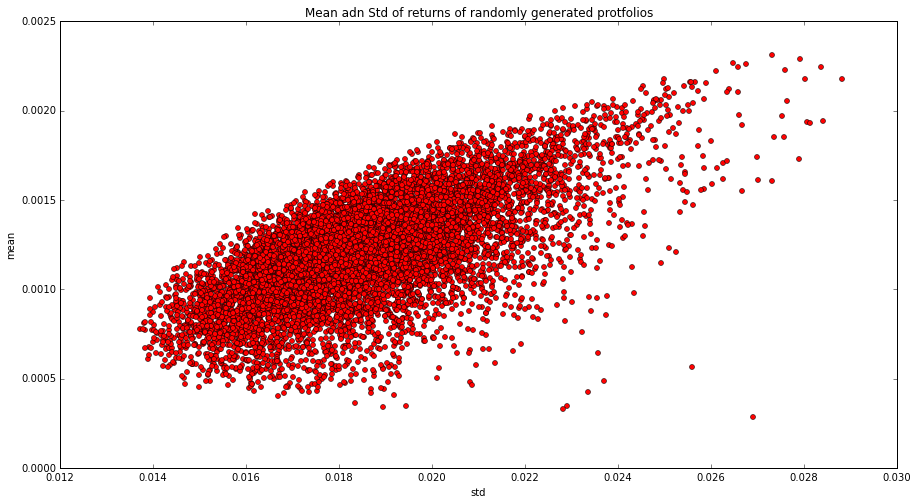

In [16]:
# Plot the random Portfolio 
PortCollection = rand_portfolio(return_vecVal, 10000)
muCollection = []
SigmaCollection = []
for item in PortCollection:
    muCollection.append(item[0])
    SigmaCollection.append(item[1])
plt.plot(SigmaCollection, muCollection, 'or', markersize = 5 )
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean adn Std of returns of randomly generated protfolios')
plt.gcf().set_size_inches(15,8)


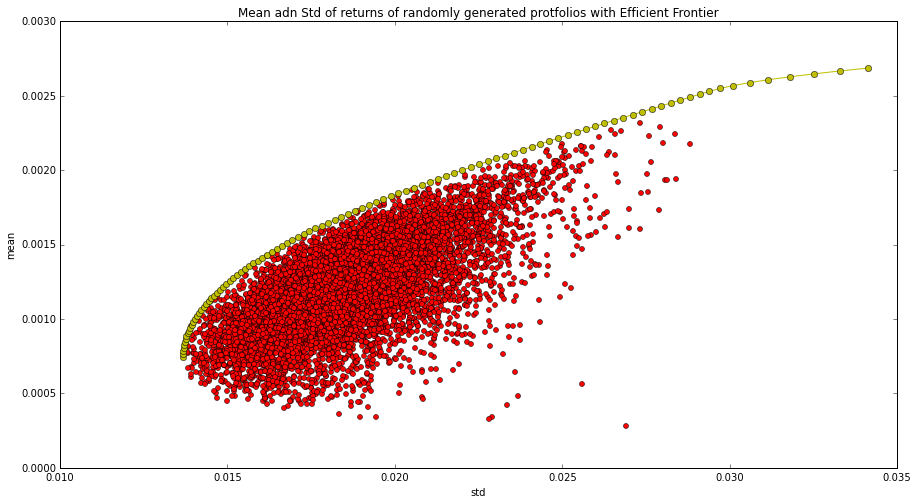

In [19]:
# Optimal Portfolio:
def Opt_Portfoio(returns, N):
    n = returns.shape[1]
    Cov = opt.matrix(np.cov(returns.T))
    means = opt.matrix(np.mean(returns, axis = 0))
    
    #Create the contraints 
    G = -opt.matrix(np.eye(n))
    h = opt.matrix(0.0, (n,1))
    A = opt.matrix(1.0, (1,n))
    b = opt.matrix(1.0)
    #Find global mininum risk
    q = opt.matrix(0.0,(n, 1))
    minStdW = solvers.qp(Cov, q, G, h, A, b)['x']
    minMu = minStdW.T * means
    maxMu = max(means)
    step = (maxMu - minMu)/(N-1)
    mus = [minMu + step * i for i in range(N)]
    
    #Calculate returns & risk for each Mu
    A2 = np.concatenate((A, means.T), axis = 0)
    A2 = opt.matrix(A2)
    PortCollection = []
    for mu in mus:
        b2 = np.concatenate((b, mu), axis = 0)
        b2 = opt.matrix(b2)
        w_temp = solvers.qp(Cov, q, G, h, A2, b2)['x']
        sigma = np.sqrt(w_temp.T * Cov * w_temp)
        sigma = np.squeeze(sigma.tolist()).tolist()
        mu = np.squeeze(np.asmatrix(mu).tolist()).tolist()
        PortCollection.append((mu, sigma))
    
        
    return PortCollection
#Test
Res = Opt_Portfoio(return_vecVal, 100)
sigmas = []
mus = []
for item in Res:
    sigmas.append(item[1])
    mus.append(item[0])

plt.plot(SigmaCollection, muCollection, 'or', markersize = 5 )
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean adn Std of returns of randomly generated protfolios with Efficient Frontier')
plt.plot(sigmas, mus, 'o-y')
plt.gcf().set_size_inches(15,8)

    
    
    

In [27]:
# Optimal Portfolio with short 

def Opt_Portfoio_with_short(returns, N):
    n = returns.shape[1]
    Cov = opt.matrix(np.cov(returns.T))
    means = opt.matrix(np.mean(returns, axis = 0))
    
    #Create the contraints 
    G = -opt.matrix(np.zeros((n,n)))
    h = opt.matrix(0.0, (n,1))
    A = opt.matrix(1.0, (1,n))
    b = opt.matrix(1.0)
    #Find global mininum risk
    q = opt.matrix(0.0,(n, 1))
    minStdW = solvers.qp(Cov, q, G, h, A, b)['x']
    minMu = minStdW.T * means
    maxMu = max(means)
    step = (maxMu - minMu)/(N-1)
    mus = [minMu + step * i for i in range(N)]
    
    #Calculate returns & risk for each Mu
    A2 = np.concatenate((A, means.T), axis = 0)
    A2 = opt.matrix(A2)
    PortCollection = []
    for mu in mus:
        b2 = np.concatenate((b, mu), axis = 0)
        b2 = opt.matrix(b2)
        w_temp = solvers.qp(Cov, q, G, h, A2, b2)['x']
        sigma = np.sqrt(w_temp.T * Cov * w_temp)
        sigma = np.squeeze(sigma.tolist()).tolist()
        mu = np.squeeze(np.asmatrix(mu).tolist()).tolist()
        PortCollection.append((mu, sigma))
    return PortCollection

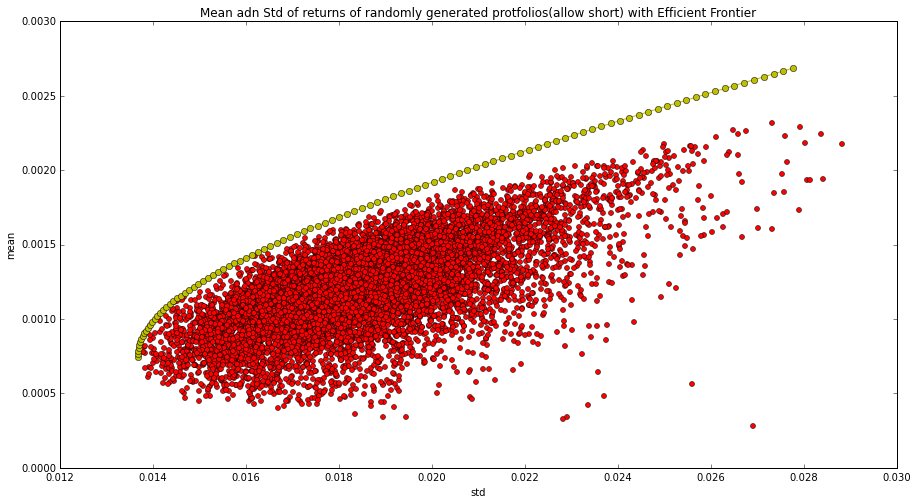

In [28]:
#Test

Res = Opt_Portfoio_with_short(return_vecVal, 100)
sigmas = []
mus = []
for item in Res:
    sigmas.append(item[1])
    mus.append(item[0])

plt.plot(SigmaCollection, muCollection, 'or', markersize = 5 )
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean adn Std of returns of randomly generated protfolios(allow short) with Efficient Frontier')
plt.plot(sigmas, mus, 'o-y')
plt.gcf().set_size_inches(15,8)

    

In [97]:
#Portfolio with Risk Free Rate 
def Opt_Portfoio_with_RF(returns, N, rf, option = 'NS'):
    rf_daily = rf/250
    n = returns.shape[1]
    Cov = opt.matrix(np.cov(returns.T))
    row = np.zeros((n ,1))
    col = np.zeros((1,n + 1))
    Cov = np.append(Cov, row, axis = 1)
    Cov = np.append(Cov, col, axis = 0)
    Cov = opt.matrix(Cov)
    means = opt.matrix(np.mean(returns, axis = 0))
    means = np.append(means, rf_daily)
    means = opt.matrix(means)
    
    
    #Create the contraints 
    G = None
    if(option is "S"):
        G = -opt.matrix(np.zeros((n + 1,n + 1)))
    else:
        G = -opt.matrix(np.eye(n + 1,n + 1))
    h = opt.matrix(0.0, (n + 1,1))
    A = opt.matrix(1.0, (1,n + 1))
    b = opt.matrix(1.0)
    #Find global mininum risk
    q = opt.matrix(0.0,(n + 1, 1))
    minStdW = solvers.qp(Cov, q, G, h, A, b)['x']
    minMu = minStdW.T * means
    maxMu = max(means)
    step = (maxMu - minMu)/(N-1)
    mus = [minMu + step * i for i in range(N)]
    
    #Calculate returns & risk for each Mu
    A2 = np.concatenate((A, means.T), axis = 0)
    A2 = opt.matrix(A2)
    PortCollection = []
    for mu in mus:
        b2 = np.concatenate((b, mu), axis = 0)
        b2 = opt.matrix(b2)
        w_temp = solvers.qp(Cov, q, G, h, A2, b2)['x']
        sigma = np.sqrt(w_temp.T * Cov * w_temp)
        sigma = np.squeeze(sigma.tolist()).tolist()
        mu = np.squeeze(np.asmatrix(mu).tolist()).tolist()
        PortCollection.append((mu, sigma))
    return PortCollection

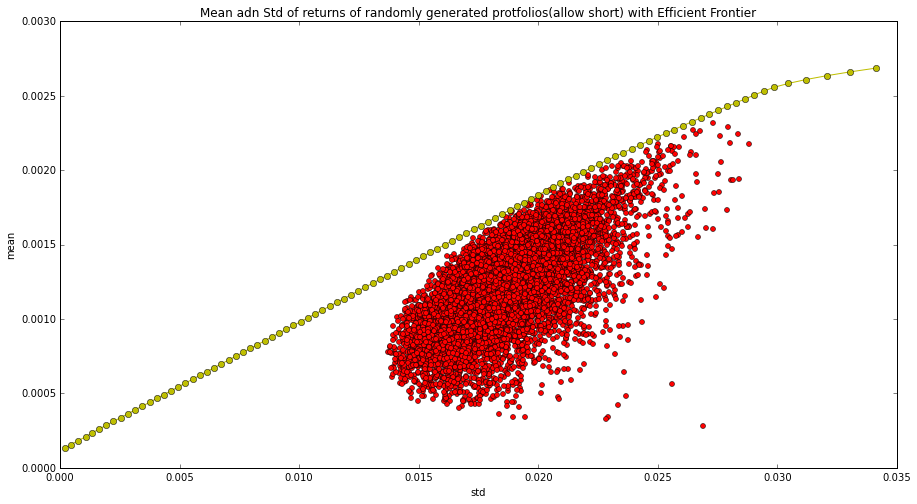

In [99]:
#Test
Res = Opt_Portfoio_with_RF(return_vecVal, 100, 0.03)
sigmas = []
mus = []
for item in Res:
    sigmas.append(item[1])
    mus.append(item[0])

plt.plot(SigmaCollection, muCollection, 'or', markersize = 5 )
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean adn Std of returns of randomly generated protfolios(allow short) with Efficient Frontier')
plt.plot(sigmas, mus, 'o-y')
plt.gcf().set_size_inches(15,8)

